In [42]:
# run this cell
from datascience import *
from pandas import read_stata
import numpy as np

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In this exercise we will join data to learn about the education of teen mothers and thier children in urban Colombia from the 2016 ELCA survey.  Upload the roster data.

In [43]:
filename = 'Colombia Roster.csv'
colombia_roster = Table.read_table(filename)
colombia_roster

hhid,roster_id,age,sex,mother_id,education_complete,current_grade
1,1,60,Mujer,nan,beyond secondary,nan
1,6,40,Mujer,1,beyond secondary,nan
1,7,67,Hombre,nan,beyond secondary,nan
1,8,22,Hombre,6,beyond secondary,nan
2,1,53,Mujer,nan,beyond secondary,nan
2,2,25,Hombre,1,beyond secondary,nan
2,3,22,Mujer,1,beyond secondary,13
2,4,30,Mujer,1,beyond secondary,nan
2,5,6,Hombre,4,beyond secondary,2
2,6,31,Hombre,nan,beyond secondary,nan


First, we need to figure out who were teen mothers.  For each mother on the roster, keep the oldest child. (use motherid)  
This requires a number of steps: figure out who is the oldest child and then link that child's age to the mother's observation 

Keep only the variables householdid, mother_id and age. Rename motherID as indivID and rename age as childage.  Combine hhID & indivID into a unique_indivID

In [44]:
children = colombia_roster.select('hhid', 'mother_id', 'age')
children.relabel('mother_id', 'indivID').relabel('age', 'childage')
children = children.where('indivID', are.above(0))
children

hhid,indivID,childage
1,1,40
1,6,22
2,1,25
2,1,22
2,1,30
2,4,6
2,4,3
3,2,12
4,1,13
4,1,7


Create a mother id so we can group by this to find the oldest age

In [45]:
mother_unique_id = children.column('...') * 1000 + children.column('...')
mother_unique_id

array([  1.00100000e+03,   1.00600000e+03,   2.00100000e+03, ...,
         4.86000200e+06,   4.86000300e+06,   4.86000300e+06])

Now we don't need hhid or indivID

In [46]:
children = children.with_column('mother_uniqueid', mother_unique_id)
children = children.select('childage', 'mother_uniqueid')
children

childage,mother_uniqueid
40,1001
22,1006
25,2001
22,2001
30,2001
6,2004
3,2004
12,3002
13,4001
7,4001


Find the oldest age of each mother.

In [47]:
oldest_children = children.group('mother_uniqueid', max)
oldest_children

mother_uniqueid,childage max
1001,40
1006,22
2001,30
2004,6
3002,12
4001,13
5002,7
7002,28
7004,5
8001,21


Link this to the mother.  Open the roster data set again, create the unique_indivID combining hhID &indivID & join the data sets.

In [48]:
unique_id = colombia_roster.column('...') * 1000 + colombia_roster.column('...')
unique_id

array([   1001,    1006,    1007, ..., 4860003, 4860004, 4860005], dtype=int64)

In [49]:
colombia_roster = colombia_roster.with_column('unique_id', unique_id)
colombia_roster = colombia_roster.with_column('mother_uniqueid', unique_id)
colombia_roster

hhid,roster_id,age,sex,mother_id,education_complete,current_grade,unique_id,mother_uniqueid
1,1,60,Mujer,nan,beyond secondary,nan,1001,1001
1,6,40,Mujer,1,beyond secondary,nan,1006,1006
1,7,67,Hombre,nan,beyond secondary,nan,1007,1007
1,8,22,Hombre,6,beyond secondary,nan,1008,1008
2,1,53,Mujer,nan,beyond secondary,nan,2001,2001
2,2,25,Hombre,1,beyond secondary,nan,2002,2002
2,3,22,Mujer,1,beyond secondary,13,2003,2003
2,4,30,Mujer,1,beyond secondary,nan,2004,2004
2,5,6,Hombre,4,beyond secondary,2,2005,2005
2,6,31,Hombre,nan,beyond secondary,nan,2006,2006


In [50]:
# Join only keeps individuals who have children in the data
mothers = colombia_roster.join('mother_uniqueid', oldest_children)
mothers

mother_uniqueid,hhid,roster_id,age,sex,mother_id,education_complete,current_grade,unique_id,childage max
1001,1,1,60,Mujer,nan,beyond secondary,nan,1001,40
1006,1,6,40,Mujer,1,beyond secondary,nan,1006,22
2001,2,1,53,Mujer,nan,beyond secondary,nan,2001,30
2004,2,4,30,Mujer,1,beyond secondary,nan,2004,6
3002,3,2,40,Mujer,nan,beyond secondary,nan,3002,12
4001,4,1,29,Mujer,nan,beyond secondary,nan,4001,13
5002,5,2,38,Mujer,nan,beyond secondary,nan,5002,7
7002,7,2,59,Mujer,nan,beyond secondary,nan,7002,28
7004,7,4,28,Mujer,2,beyond secondary,15,7004,5
8001,8,1,38,Mujer,nan,beyond secondary,9,8001,21


Use Mother's age and age of oldest child to calculate mother's age at first birth.

In [51]:
age_first_birth = mothers.column('...') - mothers.column('...')
mothers = mothers.with_column('age first birth', age_first_birth)
mothers

mother_uniqueid,hhid,roster_id,age,sex,mother_id,education_complete,current_grade,unique_id,childage max,age first birth
1001,1,1,60,Mujer,nan,beyond secondary,nan,1001,40,20
1006,1,6,40,Mujer,1,beyond secondary,nan,1006,22,18
2001,2,1,53,Mujer,nan,beyond secondary,nan,2001,30,23
2004,2,4,30,Mujer,1,beyond secondary,nan,2004,6,24
3002,3,2,40,Mujer,nan,beyond secondary,nan,3002,12,28
4001,4,1,29,Mujer,nan,beyond secondary,nan,4001,13,16
5002,5,2,38,Mujer,nan,beyond secondary,nan,5002,7,31
7002,7,2,59,Mujer,nan,beyond secondary,nan,7002,28,31
7004,7,4,28,Mujer,2,beyond secondary,15,7004,5,23
8001,8,1,38,Mujer,nan,beyond secondary,9,8001,21,17


Make a histogram of mother's age at first birth.  Remove crazy outliers.

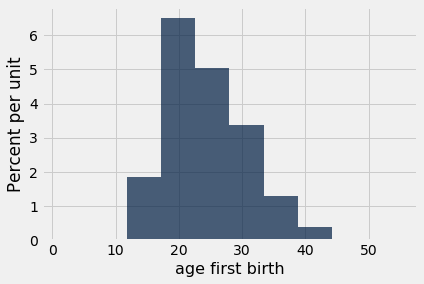

In [52]:
...

Make a new "TeenMom" variable indicating women who had thier oldest child before age 20. Save this data table. (We probably missed some women who were teen mothers - why?)  

In [53]:
teen_mom = []
for i in mothers.column('age first birth'):
    if i < 20:
        teen_mom.append('Yes')
    else:
        teen_mom.append('No')
mothers = mothers.with_column('Teen Mom', teen_mom)
mothers

mother_uniqueid,hhid,roster_id,age,sex,mother_id,education_complete,current_grade,unique_id,childage max,age first birth,Teen Mom
1001,1,1,60,Mujer,nan,beyond secondary,nan,1001,40,20,No
1006,1,6,40,Mujer,1,beyond secondary,nan,1006,22,18,Yes
2001,2,1,53,Mujer,nan,beyond secondary,nan,2001,30,23,No
2004,2,4,30,Mujer,1,beyond secondary,nan,2004,6,24,No
3002,3,2,40,Mujer,nan,beyond secondary,nan,3002,12,28,No
4001,4,1,29,Mujer,nan,beyond secondary,nan,4001,13,16,Yes
5002,5,2,38,Mujer,nan,beyond secondary,nan,5002,7,31,No
7002,7,2,59,Mujer,nan,beyond secondary,nan,7002,28,31,No
7004,7,4,28,Mujer,2,beyond secondary,15,7004,5,23,No
8001,8,1,38,Mujer,nan,beyond secondary,9,8001,21,17,Yes


What percentage of women were teen mothers?

In [54]:
mothers.group('...')

Teen Mom,count
No,3962
Yes,1239


How does the level of education of women who were teen mothers compared to non-teen mothers?

In [55]:
mothers.where('...', '...').group('...')

education_complete,count
beyond secondary,1239


In [56]:
...

education_complete,count
beyond secondary,3962


Now let's see if children of teen mothers have worse education than children of women who were not teen mothers.  We will need to merge in the TeenMom variable to the child data. Drop unique_motherID and rename unique_indivID.  Save only the variables unique_indivID and TeenMom in this small table.

In [58]:
mother_info = mothers.select('mother_uniqueid', 'Teen Mom', 'age')
mother_info = mother_info.relabel('...', 'mother age')
mother_info

mother_uniqueid,Teen Mom,mother age
1001,No,60
1006,Yes,40
2001,No,53
2004,No,30
3002,No,40
4001,Yes,29
5002,No,38
7002,No,59
7004,No,28
8001,Yes,38


In [29]:
# this will be our children with mother info table, but the mother info is not yet joined.
children_with_mother_info = colombia_roster.drop('mother_uniqueid')
children_with_mother_info = children_with_mother_info.where('mother_id', are.above(0))
children_with_mother_info

Create a mother unique ID

In [59]:
mother_uniqueid = children_with_mother_info.column('...') * 1000 + children_with_mother_info.column('...')
children_with_mother_info = children_with_mother_info.with_column('mother_uniqueid', mother_uniqueid )
children_with_mother_info

mother_uniqueid,hhid,roster_id,age,sex,mother_id,education_complete,current_grade,unique_id,Teen Mom,mother age
1001,1,6,40,Mujer,1,beyond secondary,nan,1006,No,60
1006,1,8,22,Hombre,6,beyond secondary,nan,1008,Yes,40
2001,2,2,25,Hombre,1,beyond secondary,nan,2002,No,53
2001,2,3,22,Mujer,1,beyond secondary,13,2003,No,53
2001,2,4,30,Mujer,1,beyond secondary,nan,2004,No,53
2004,2,5,6,Hombre,4,beyond secondary,2,2005,No,30
2004,2,7,3,Mujer,4,beyond secondary,nan,2007,No,30
3002,3,4,12,Mujer,2,beyond secondary,7,3004,No,40
4001,4,2,13,Hombre,1,beyond secondary,8,4002,Yes,29
4001,4,3,7,Mujer,1,beyond secondary,3,4003,Yes,29


Join Mother info to the Child

In [60]:
children_with_mother_info = children_with_mother_info.join('mother_uniqueid', mother_info)
children_with_mother_info

mother_uniqueid,hhid,roster_id,age,sex,mother_id,education_complete,current_grade,unique_id,Teen Mom,mother age,Teen Mom_2,mother age_2
1001,1,6,40,Mujer,1,beyond secondary,nan,1006,No,60,No,60
1006,1,8,22,Hombre,6,beyond secondary,nan,1008,Yes,40,Yes,40
2001,2,2,25,Hombre,1,beyond secondary,nan,2002,No,53,No,53
2001,2,3,22,Mujer,1,beyond secondary,13,2003,No,53,No,53
2001,2,4,30,Mujer,1,beyond secondary,nan,2004,No,53,No,53
2004,2,5,6,Hombre,4,beyond secondary,2,2005,No,30,No,30
2004,2,7,3,Mujer,4,beyond secondary,nan,2007,No,30,No,30
3002,3,4,12,Mujer,2,beyond secondary,7,3004,No,40,No,40
4001,4,2,13,Hombre,1,beyond secondary,8,4002,Yes,29,Yes,29
4001,4,3,7,Mujer,1,beyond secondary,3,4003,Yes,29,Yes,29


What percentage of children had mothers who were teen mothers?  Only consider chidlren < age 19

In [63]:
children_with_mother_info.where(...)...

Teen Mom,count
No,3800
Yes,1983


Let's examine the education of the children.  Only keep the ones currently attending.

In [35]:
enrolled_children = children_with_mother_info.where('...', are.above(0))
enrolled_children

mother_uniqueid,hhid,roster_id,age,sex,mother_id,education_complete,current_grade,unique_id,Teen Mom,mother age
2001,2,3,22,Mujer,1,beyond secondary,13,2003,No,53
2004,2,5,6,Hombre,4,beyond secondary,2,2005,No,30
3002,3,4,12,Mujer,2,beyond secondary,7,3004,No,40
4001,4,2,13,Hombre,1,beyond secondary,8,4002,Yes,29
4001,4,3,7,Mujer,1,beyond secondary,3,4003,Yes,29
5002,5,3,7,Hombre,2,beyond secondary,2,5003,No,38
7002,7,4,28,Mujer,2,beyond secondary,15,7004,No,59
8001,8,5,16,Mujer,1,beyond secondary,8,8005,Yes,38
9001,9,2,16,Hombre,1,beyond secondary,10,9002,Yes,35
9001,9,3,7,Hombre,1,beyond secondary,2,9003,Yes,35


Find the average grade for each age.

In [36]:
mean_grade_enrolled_children = enrolled_children.group('...', np.mean).select('age', 'current_grade mean')
mean_grade_enrolled_children = mean_grade_enrolled_children.relabel('current_grade mean', 'mean grade')
mean_grade_enrolled_children = mean_grade_enrolled_children.where('...', are.below(19))
mean_grade_enrolled_children

age,mean grade
5,1
6,1.14828
7,1.92711
8,2.82514
9,3.63662
10,4.49284
11,5.4139
12,6.37537
13,7.22316
14,8.08772


Join that mean grade to the child & their actual grade.

In [37]:
enrolled_children = enrolled_children.join('age', mean_grade_enrolled_children, 'age')
enrolled_children

age,mother_uniqueid,hhid,roster_id,sex,mother_id,education_complete,current_grade,unique_id,Teen Mom,mother age,mean grade
5,687003,687,5,Mujer,3,beyond secondary,1,687005,No,37,1
5,1.19e+06,1190,5,Hombre,2,beyond secondary,1,1190005,No,33,1
5,1.479e+06,1479,4,Hombre,2,beyond secondary,1,1479004,Yes,30,1
5,2.283e+06,2283,5,Mujer,1,beyond secondary,1,2283005,No,46,1
5,4.623e+06,4623,5,Mujer,3,beyond secondary,1,4623005,Yes,26,1
6,2004,2,5,Hombre,4,beyond secondary,2,2005,No,30,1.14828
6,27007,27,8,Hombre,7,beyond secondary,1,27008,No,31,1.14828
6,27007,27,9,Hombre,7,beyond secondary,1,27009,No,31,1.14828
6,36002,36,4,Mujer,2,beyond secondary,1,36004,No,31,1.14828
6,51002,51,4,Hombre,2,beyond secondary,1,51004,Yes,28,1.14828


Calculate if the child is delayed by more than 1 year for their age.

In [38]:
delayed_edu = (enrolled_children.column('current_grade') + ...) - enrolled_children.column('mean grade')
delayed_edu

array([ 1.     ,  1.     ,  1.     , ..., -7.76875,  3.23125,  2.23125])

In [39]:
delayed = []
for i in delayed_edu:
    if i < 0:
        delayed.append('Yes')
    else:
        delayed.append('No')
enrolled_children = enrolled_children.with_column('delayed', delayed)
enrolled_children

age,mother_uniqueid,hhid,roster_id,sex,mother_id,education_complete,current_grade,unique_id,Teen Mom,mother age,mean grade,delayed
5,687003,687,5,Mujer,3,beyond secondary,1,687005,No,37,1,No
5,1.19e+06,1190,5,Hombre,2,beyond secondary,1,1190005,No,33,1,No
5,1.479e+06,1479,4,Hombre,2,beyond secondary,1,1479004,Yes,30,1,No
5,2.283e+06,2283,5,Mujer,1,beyond secondary,1,2283005,No,46,1,No
5,4.623e+06,4623,5,Mujer,3,beyond secondary,1,4623005,Yes,26,1,No
6,2004,2,5,Hombre,4,beyond secondary,2,2005,No,30,1.14828,No
6,27007,27,8,Hombre,7,beyond secondary,1,27008,No,31,1.14828,No
6,27007,27,9,Hombre,7,beyond secondary,1,27009,No,31,1.14828,No
6,36002,36,4,Mujer,2,beyond secondary,1,36004,No,31,1.14828,No
6,51002,51,4,Hombre,2,beyond secondary,1,51004,Yes,28,1.14828,No


Are children of teen moms more or less likely to be enrolled?

In [40]:
enrolled_children.where('...', '...').group('...')

delayed,count
No,1129
Yes,234


delayed,count
No,2372
Yes,355
